In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/')
from tools import derive_var,read_and_proc,preproc_noensemble
from tools.mlr import mlr,proc_mlrfcst
from tools.preprocess import do_eof,preproc_maria
import feature_select
from dask.distributed import Client
client = Client(processes=True, threads_per_worker=1,n_workers=2)
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/tmp/ipykernel_865279/2023895885.py:23: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


##### Functions

In [2]:
#Function####################################################
import json,pickle
def output_regpredict(inTS=None,outTS=None,LTlist=None,algorithm='linear',memory='without',simplelassoalpha=0.001,do_aux=False,aux_inTS=None,minus_b=False):
    if memory=='with':
        output = []
        for i in range(len(outTS)):
            inarray = np.concatenate(((inTS[:-int(LTlist[i])][int(LTlist[i]):]),(inTS[:-int(LTlist[i])][0:-int(LTlist[i])])),axis=1)
            outarray = outTS[i][int(LTlist[i]):-int(LTlist[i])]
            output.append(produce_regscore(inarray,outarray,None,'predict',False,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01))
        return output
    elif memory=='without':
        if do_aux is False:
            return [produce_regscore(mlr.delete_padding(inTS,outTS[i])[0],mlr.delete_padding(inTS,outTS[i])[1],None,'predict',False,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha) for i in range(len(outTS))]
        elif do_aux is True:
            if minus_b is False:
                return [mlr.produce_regscore(mlr.delete_padding(inTS,outTS[i])[0],mlr.delete_padding(inTS,outTS[i])[1],mlr.delete_padding(aux_inTS,outTS[i])[0],
                                         'predict',True,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha) for i in range(len(outTS))]
            else:
                return [mlr.produce_regscore(mlr.delete_padding(inTS,outTS[i])[0],mlr.delete_padding(inTS,outTS[i])[1],mlr.delete_padding(aux_inTS,outTS[i])[0],
                                         'aux_predict',True,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha) for i in range(len(outTS))]

#### Reconstruct - I. Input save variables

In [3]:
############################################################################################################################################
# PCA_dict: Processed EOF objects; A_dict: Variable anomaly matrices; Af_dict: Flattened variable anomaly matrices
# *note that following EOF conventions, we derived EOFs with anomalies.
############################################################################################################################################
# Basic settings
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/'
expname = ['ctl','ncrf_36h','ncrf_60h','lwcrf']
varname = ['u','v','w']
nummem = [54,26,50,5,75,36]#[22,8,35,5,19,36]#[12,3,26,5,3,19]#[36,16,44,8,6,23]
PCAdict = read_and_proc.depickle(folderpath+'PCA/ctl_PCA_dict1')
PCAtheta = read_and_proc.depickle(folderpath+'PCA/theta_PCA_dict1')
PCAdict['theta'] = PCAtheta['theta']
# Read files
flatvar = [read_and_proc.depickle(folderpath+'preproc/'+str(expname[i])+'_'+'preproc_dict1') for i in range(len(expname))]
# theta
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/flatvar/'
thetavar = read_and_proc.depickle(folderpath+'theta_'+'preproc_dict1')
vardicts = mlr.preproc_data(PCAdict,folderpath,varname,nummem).readvar(listdict=flatvar,withtheta='No',thetaflat=thetavar,smooth24=False)

del flatvar,thetavar,PCAtheta
gc.collect()
#duvwsen_dict = preproc_data('/scratch/08350/tg876493/ruppert2020/output/',['du','dv','dw']).senfile('/ctrlbase/','_CORR',True)

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


145

#### Read files

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/complex/Q95_complex/'
file2 = [path+'inputoutput/'+'inputQ95_dict_smoo6_withtheta',path+'inputoutput/'+'outputQ95_dict_smoo6_withtheta']#,path+'NOIR_dict_smoo6_withtheta',path+'IR_dict_smoo6_withtheta']
mlr_inputdict,mlr_output = read_and_proc.depickle(file2[0]),read_and_proc.depickle(file2[1])
#mlr_auxinput,mlr_aux2input=read_and_proc.depickle(file2[2]),read_and_proc.depickle(file2[3])

In [6]:
LDTME = np.linspace(0,44,45)+1#np.asarray([3,6,9,12,15,18,21,24,27,30,33,36,39,42,45])
exp = ['dt', 'dtth', 'dtthuv', 'dtthuvw', 'dtthuvwqv', 'dtuvw', 'uv']
forecastPC = [mlr.model_fitpredict(mlr_inputdict[expname],mlr_output,LinearRegression,LDTME).modelforecast(None) for expname in exp]
#IR_forecast = mlr.model_fitpredict(mlr_inputdict['dtth'],mlr_output,LinearRegression,LDTME).modelforecast(mlr_aux2input['dtth'])#mlr_input_dtuvw_onlydt)
#LDTME = np.linspace(0,44,45)+1
#IR_forecast = mlr.model_fitpredict(mlr_inputdict['dt'],mlr_output,LinearRegression,LDTME).modelforecast(mlr_input_dtuvw_onlydt)

from copy import deepcopy
mlr_input_dtuvw_onlydt = deepcopy(mlr_inputdict['dt'])#mlr_inputdict['dt'])
mlr_input_dtuvw_onlydt[58-24+4,:] = mlr_input_dtuvw_onlydt[96+86+(58-58)+4,:]

##### FeatureFeatureSelector

In [21]:
model = read_and_proc.depickle('./output/FFW/FFWmodels')
reducedX = read_and_proc.depickle('./output/FFW/reducedX')
newfeature = read_and_proc.depickle('./output/FFW/newfeature')

In [34]:
LDTME = np.linspace(0,44,45)+1#np.asarray([3,6,9,12,15,18,21,24,27,30,33,36,39,42,45])
exp = ['dt', 'dtth', 'dtthuv', 'dtthuvw', 'dtthuvwqv', 'dtuvw', 'uv']
inputdict = np.concatenate((mlr_inputdict['dtthuvw'][:,newfeature[0:20]],mlr_inputdict['dt']),axis=1)
# = mlr.model_fitpredict(inputdict,mlr_output,LinearRegression,LDTME).modelforecast(None)
linreg,_ = mlr.model_fitpredict(mlr_inputdict['dt'],mlr_output,LinearRegression,LDTME).modelfit()
#IR_forecast = mlr.model_fitpredict(mlr_inputdict['dtth'],mlr_output,LinearRegression,LDTME).modelforecast(mlr_aux2input['dtth'])#mlr_input_dtuvw_onlydt)

from copy import deepcopy
mlr_input_dtuvw_onlydt = deepcopy(inputdict)#mlr_inputdict['dt'])
mlr_input_dtuvw_onlydt[58-24+4,:] = mlr_input_dtuvw_onlydt[96+86+(58-58)+4,:]

In [56]:
reducedX[20].shape

(234, 57)

In [58]:
weight = model[20].coef_
WEIGHTZ = np.zeros_like(weight)
for weightz in range(reducedX[20].shape[1]):
    tempweight = weight[:,weightz]
    tstemp = reducedX[20][:,weightz]
    temp = np.nanmean(np.asarray([temp*tstemp for temp in tempweight]),axis=1)
    WEIGHTZ[:,weightz] = temp

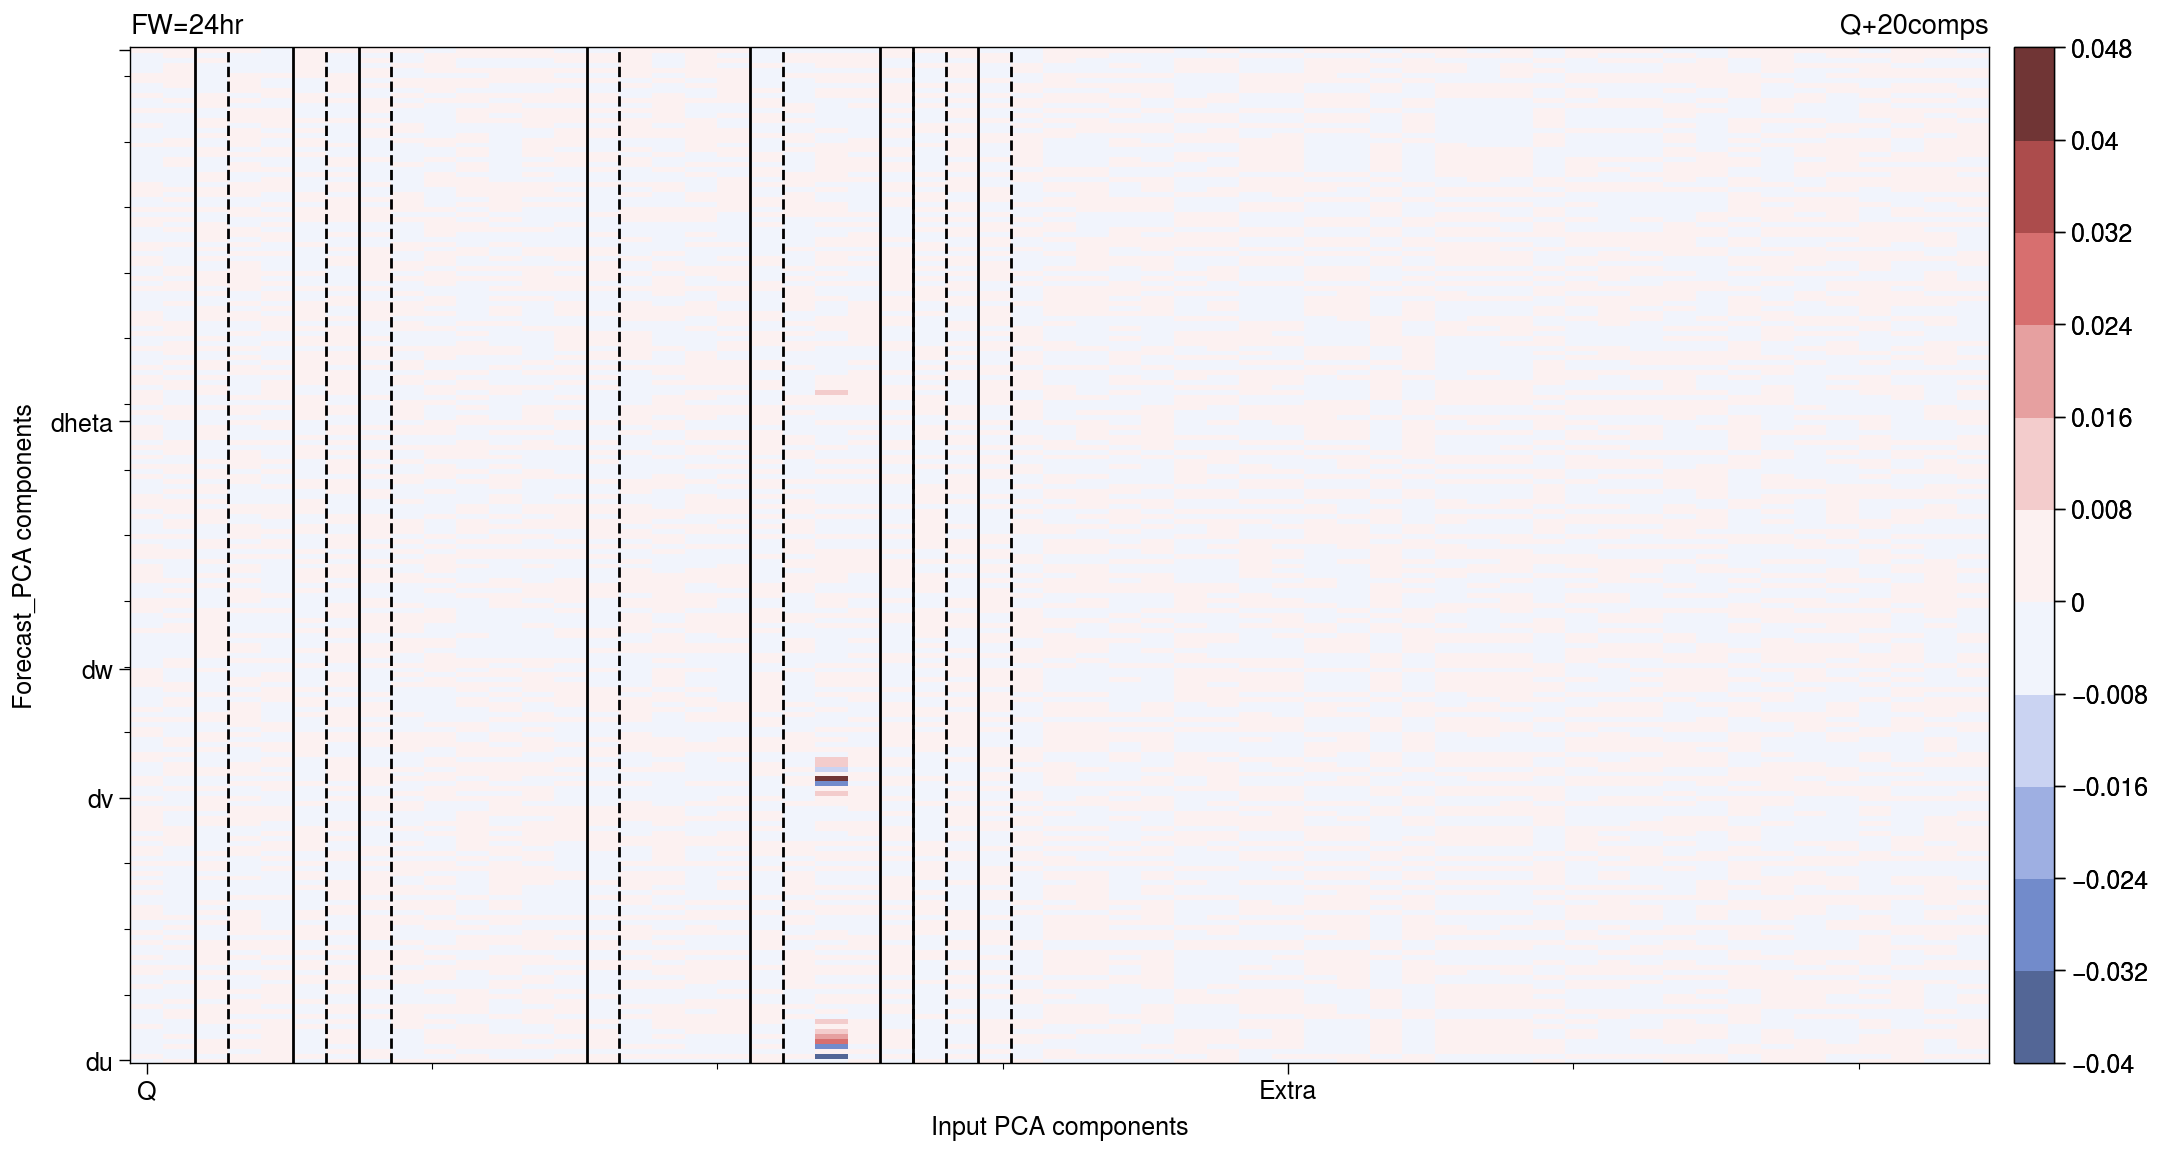

In [80]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=9.295,refaspect=1.831)
#img=axs[0].pcolormesh((model[20].coef_),cmap='Div')
img=axs[0].pcolormesh((WEIGHTZ),cmap='Div')
for i in [2-0.5,5-0.5,7-0.5,14-0.5,19-0.5,23-0.5,24-0.5,26-0.5]:
    axs[0].axvline(x=i,lw=1,c='k')
for i in [2-0.5+1,5-0.5+1,7-0.5+1,14-0.5+1,19-0.5+1,23-0.5+1,24-0.5+1,26-0.5+1]:
    axs[0].axvline(x=i,lw=1,c='k',ls='--')
#img=axs[0].pcolormesh((linreg[24].coef_),cmap='RdBu')
plt.colorbar(img)
axs[0].format(yticks=[0,53,53+26,53+26+50,53+26+50+75],yticklabels=['du','dv','dw','d$\theta$'],xticks=[0,35],xticklabels=['Q','Extra'],xlabel='Input PCA components',ylabel='Forecast_PCA components',rtitle=r'Q+20comps',ltitle='FW=24hr')
#plt.savefig('./figures/fortom_pic1.png',dpi=300)
plt.show()

In [89]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

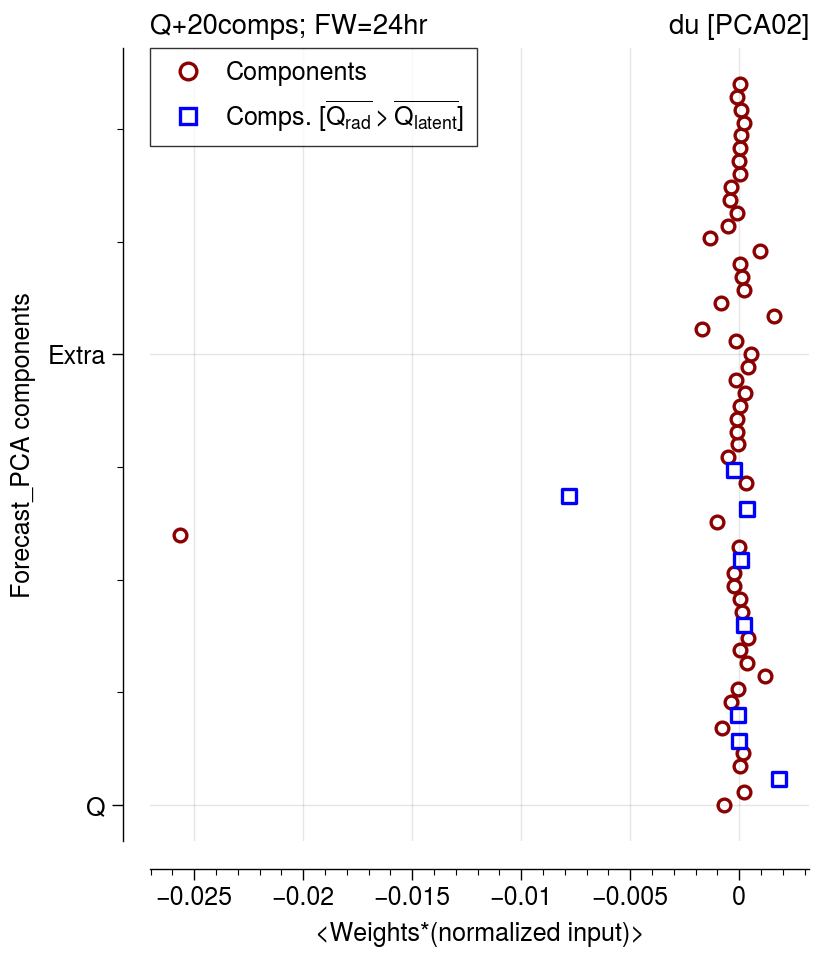

In [103]:
from matplotlib.lines import Line2D
comps = 3
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.295,refaspect=0.831)
axs[0].scatter(x=WEIGHTZ[comps,:],y=np.linspace(0,56,57),s=21,marker='o',c='w',linewidths=1.2,edgecolors='darkred')
for i in [2,5,7,14,19,23,24,26]:
    axs[0].scatter(x=WEIGHTZ[comps,i],y=i,s=24,marker='s',c='w',linewidths=1.2,edgecolors='blue')
axs[0].format(yticks=[0,35],yticklabels=['Q','Extra'],xlabel='<Weights*(normalized input)>',ylabel='Forecast_PCA components',rtitle=r'du [PCA02]',ltitle='Q+20comps; FW=24hr')

custom_lines = [Line2D([0],[0],color='k',lw=0,marker='o',markersize=6,mfc='w',mec='darkred',mew=1.2),Line2D([0],[0],color='k',lw=0,marker='s',markersize=6,mfc='w',mec='b',mew=1.2)]
axs[0].legend(custom_lines, ['Components', 'Comps. [$\overline{Q_{rad}}>\overline{Q_{latent}}$]'],prop={'size':9},ncol=1)

adjust_spines(axs[0], ['left', 'bottom'])
#plt.savefig('./figures/fortom_showweights_a.png',dpi=300)
plt.show()

#### Visualize prediction

In [4]:
from copy import deepcopy
mlr_input_dtuvw_onlydt = deepcopy(inputdict)#mlr_inputdict['dt'])
mlr_input_dtuvw_onlydt[58-24+4,:] = mlr_input_dtuvw_onlydt[96+86+(58-58)+4,:]
IR_forecast = mlr.model_fitpredict(inputdict,mlr_output,LinearRegression,LDTME).modelforecast(mlr_input_dtuvw_onlydt)#mlr_input_dtuvw_onlydt)
numcomp = [54,26,50,75]
#retrieve_cartesian(PCA_dict=PCAdict,Af_dict=vardicts,numcomp=numcomp,LT=LDTME,\
#                   forecastPC=forecastPC).output_forecast_structure(LTchoose=[6,12,18,24,30,36,42],expname='ctl',timestep=62,savepath='/scratch/itam/maria/forecast/ctl59/')
proc_mlrfcst.retrieve_cartesian(PCA_dict=PCAdict,Af_dict=vardicts,numcomp=numcomp,LT=LDTME,\
                   forecastPC=IR_forecast).output_forecast_structure(LTchoose=[6,12,18,24,30,36,42],expname='ctl',timestep=62,savepath='/scratch/itam/maria/forecast/test/ncrf_60_59/testFFW/20/')

NameError: name 'inputdict' is not defined

In [13]:
from tools.mlr import read_mlr
import importlib
importlib.reload(read_mlr)

path = '/scratch/itam/maria/forecast/'
RECONq_dict = read_mlr.read_in_forecast(path=path,subpath=['test/ncrf_60_59/Qonly/','*62*'])
RECONirall_dict = read_mlr.read_in_forecast(path=path,subpath=['test/ncrf_60_59/','*62*'])
RECONir_dict = read_mlr.read_in_forecast(path=path,subpath=['test/ncrf_60_59/testFFW/','*62*'])
RECONir2_dict = read_mlr.read_in_forecast(path=path,subpath=['test/ncrf_60_59/testFFW/20/','*62*'])
RECONir3_dict = read_mlr.read_in_forecast(path=path,subpath=['test/ncrf_60_59/testFFW/10/','*62*'])

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

__Finish__!


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

__Finish__!


distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

__Finish__!


distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

__Finish__!


distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

__Finish__!


In [6]:
modeltime = [6,12,18,24,30,36,42]
ctrl,ncrf60 = proc_mlrfcst.validate_mlr(RECONctl_dict,modeltime).real_wind()
ctl_du,ctl_dv,ctl_wspd = proc_mlrfcst.validate_mlr(RECONctl_dict,modeltime).real_windspd(u=ctrl['u'],v=ctrl['v'],timestep=62)
ncrf60_du,ncrf60_dv,ncrf60_wspd = proc_mlrfcst.validate_mlr(RECONctl_dict,modeltime).real_windspd(u=ncrf60['u'],v=ncrf60['v'],timestep=62)

---Finish!---


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


---Finish!---


In [77]:
wspd,wspd60 = [np.max(wspdd[0,:,:]) for wspdd in ctl_wspd],[np.max(wspdd[0,:,:]) for wspdd in ncrf60_wspd]
#[np.max(np.mean(wspdd[0,:,:],axis=0)) for wspdd in ctl_wspd],[np.max(np.mean(wspdd[0,:,:],axis=0)) for wspdd in ncrf60_wspd]

In [8]:
coorpres = [1000.,  975.,  950.,  925.,  900.,  875.,  850.,  825.,  800.,  775.,
        750.,  725.,  700.,  675.,  650.,  625.,  600.,  575.,  550.,  525.,
        500.,  475.,  450.,  425.,  400.,  375.,  350.,  325.,  300.,  275.,
        250.,  225.,  200.,  175.,  150.,  125.,  100.,   75.,   50.]

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/proplot/axes/plot.py:1275: UserWarning: The following kwargs were not used by contour: 'shading'
  obj = getattr(super(), name)(*args, **kwargs)
/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/proplot/axes/plot.py:1275: UserWarning: The following kwargs were not used by contour: 'shading'
  obj = getattr(super(), name)(*args, **kwargs)


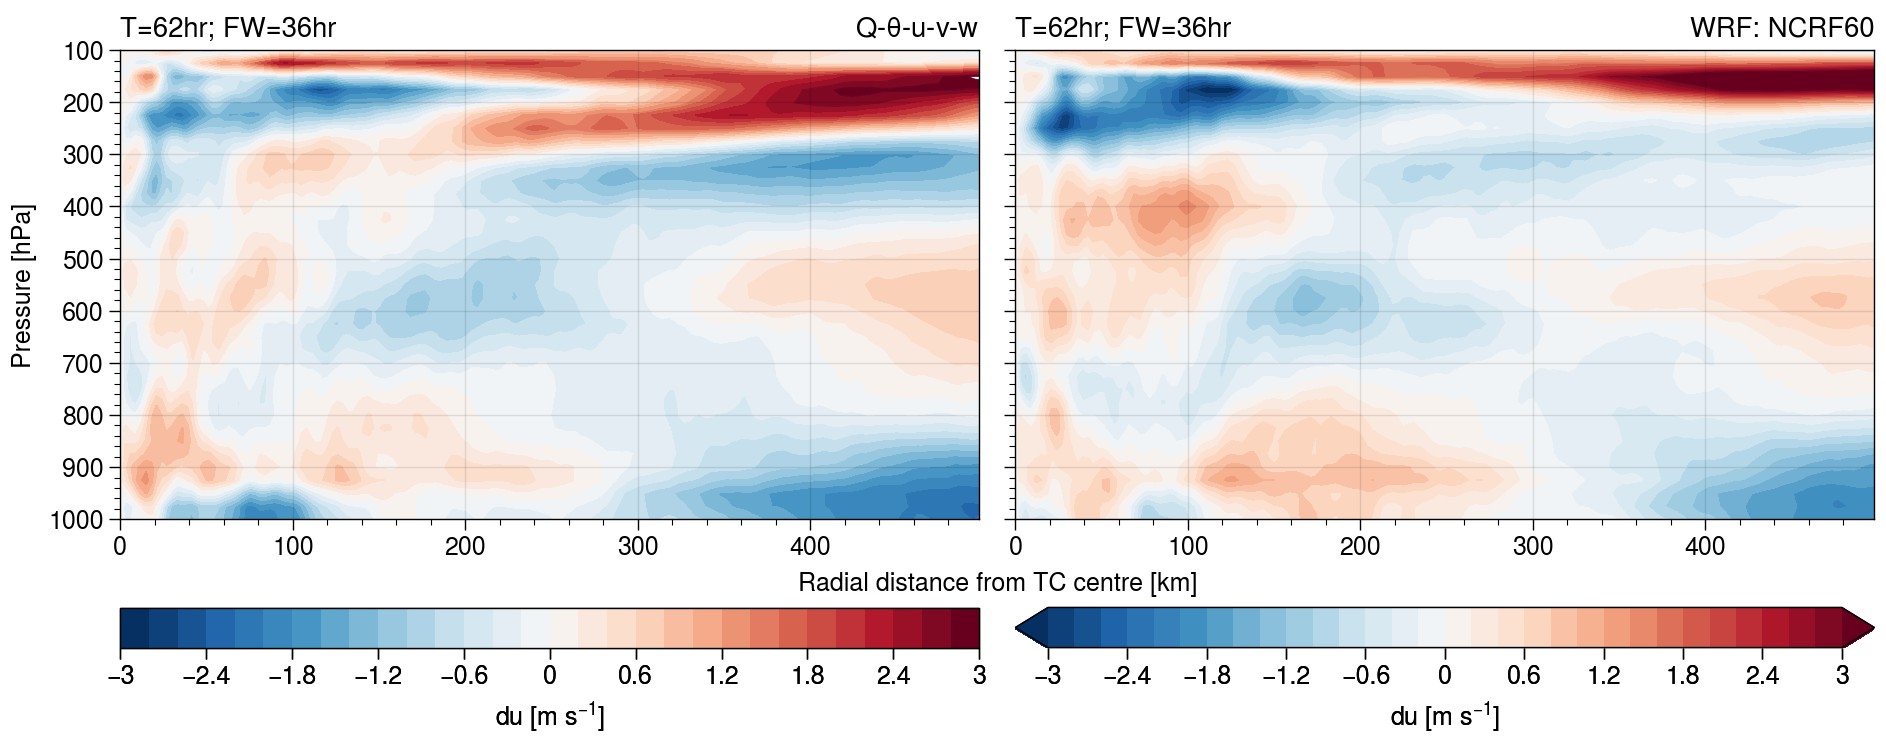

distributed.utils_perf - WARNING - full garbage collections took 95% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


In [51]:
# -8,8,33
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=4.295,refaspect=1.831)
mapp = axs[0].contourf(np.linspace(0,166,167)*3,coorpres,np.nanmean(RECONir_dict['du'][5],axis=(1))*(36*60*60),cmap='RdBu_r',levels=np.linspace(-3,3,31),shading='auto')
axs[0].format(ylim=[1000,100],xlabel='Radial distance from TC centre [km]',ylabel='Pressure [hPa]',rtitle=r'Q-$\theta$-u-v-w',ltitle='T=62hr; FW=36hr')
axs[0].colorbar(mapp,loc='b',label='du [m s$^{-1}$]')

mapp=axs[1].contourf(np.linspace(0,166,167)*3,coorpres,np.nanmean(ncrf60_du[5],axis=(1)),cmap='RdBu_r',levels=np.linspace(-3,3,31),shading='auto',extend='both')
axs[1].format(ylim=[1000,100],xlabel='Radial distance from TC centre [km]',ylabel='Pressure [hPa]',rtitle=r'WRF: NCRF60',ltitle='T=62hr; FW=36hr')
axs[1].colorbar(mapp,loc='b',label='du [m s$^{-1}$]')
plt.savefig('./figures/0316/aximean_du.png',dpi=300)
plt.show()

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/proplot/axes/plot.py:1275: UserWarning: The following kwargs were not used by contour: 'shading'
  obj = getattr(super(), name)(*args, **kwargs)
/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/proplot/axes/plot.py:1275: UserWarning: The following kwargs were not used by contour: 'shading'
  obj = getattr(super(), name)(*args, **kwargs)


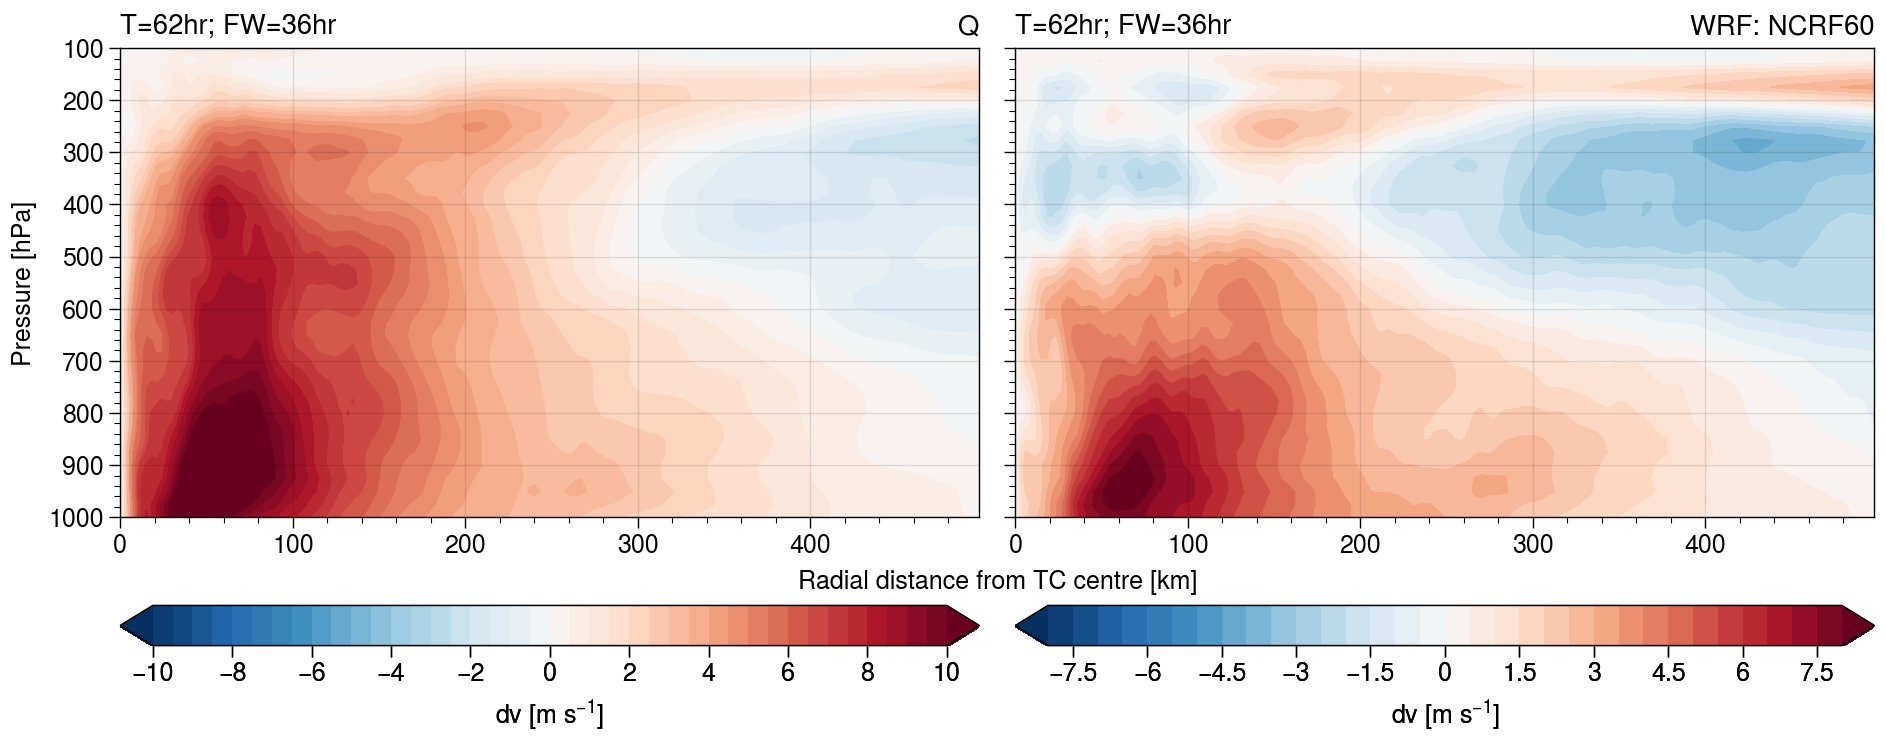

In [49]:
# -8,8,33
var='v'
if var=='v':
    clv = np.linspace(-8,8,33)
elif var=='u':
    clv = np.linspace(-3,3,31)
    
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=4.295,refaspect=1.831)
mapp = axs[0].contourf(np.linspace(0,166,167)*3,coorpres,np.nanmean(RECONir_dict['d'+str(var)][5],axis=(1))*(36*60*60),cmap='RdBu_r',levels=np.linspace(-10,10,41),shading='auto',extend='both')
axs[0].format(ylim=[1000,100],xlabel='Radial distance from TC centre [km]',ylabel='Pressure [hPa]',rtitle=r'Q',ltitle='T=62hr; FW=36hr') #-$\theta$-u-v-w
axs[0].colorbar(mapp,loc='b',label='d'+str(var)+' [m s$^{-1}$]')

mapp=axs[1].contourf(np.linspace(0,166,167)*3,coorpres,np.nanmean(ncrf60_dv[5],axis=(1)),cmap='RdBu_r',levels=clv,shading='auto',extend='both')
axs[1].format(ylim=[1000,100],xlabel='Radial distance from TC centre [km]',ylabel='Pressure [hPa]',rtitle=r'WRF: NCRF60',ltitle='T=62hr; FW=36hr')
axs[1].colorbar(mapp,loc='b',label='d'+str(var)+' [m s$^{-1}$]')
plt.savefig('./figures/0316/aximean_d'+str(var)+'_Qonly.png',dpi=300)
plt.show()

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/proplot/axes/plot.py:1275: UserWarning: The following kwargs were not used by contour: 'shading'
  obj = getattr(super(), name)(*args, **kwargs)
/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/proplot/axes/plot.py:1275: UserWarning: The following kwargs were not used by contour: 'shading'
  obj = getattr(super(), name)(*args, **kwargs)
/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/proplot/axes/plot.py:1275: UserWarning: The following kwargs were not used by contour: 'shading'
  obj = getattr(super(), name)(*args, **kwargs)
/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/proplot/axes/plot.py:1275: UserWarnin

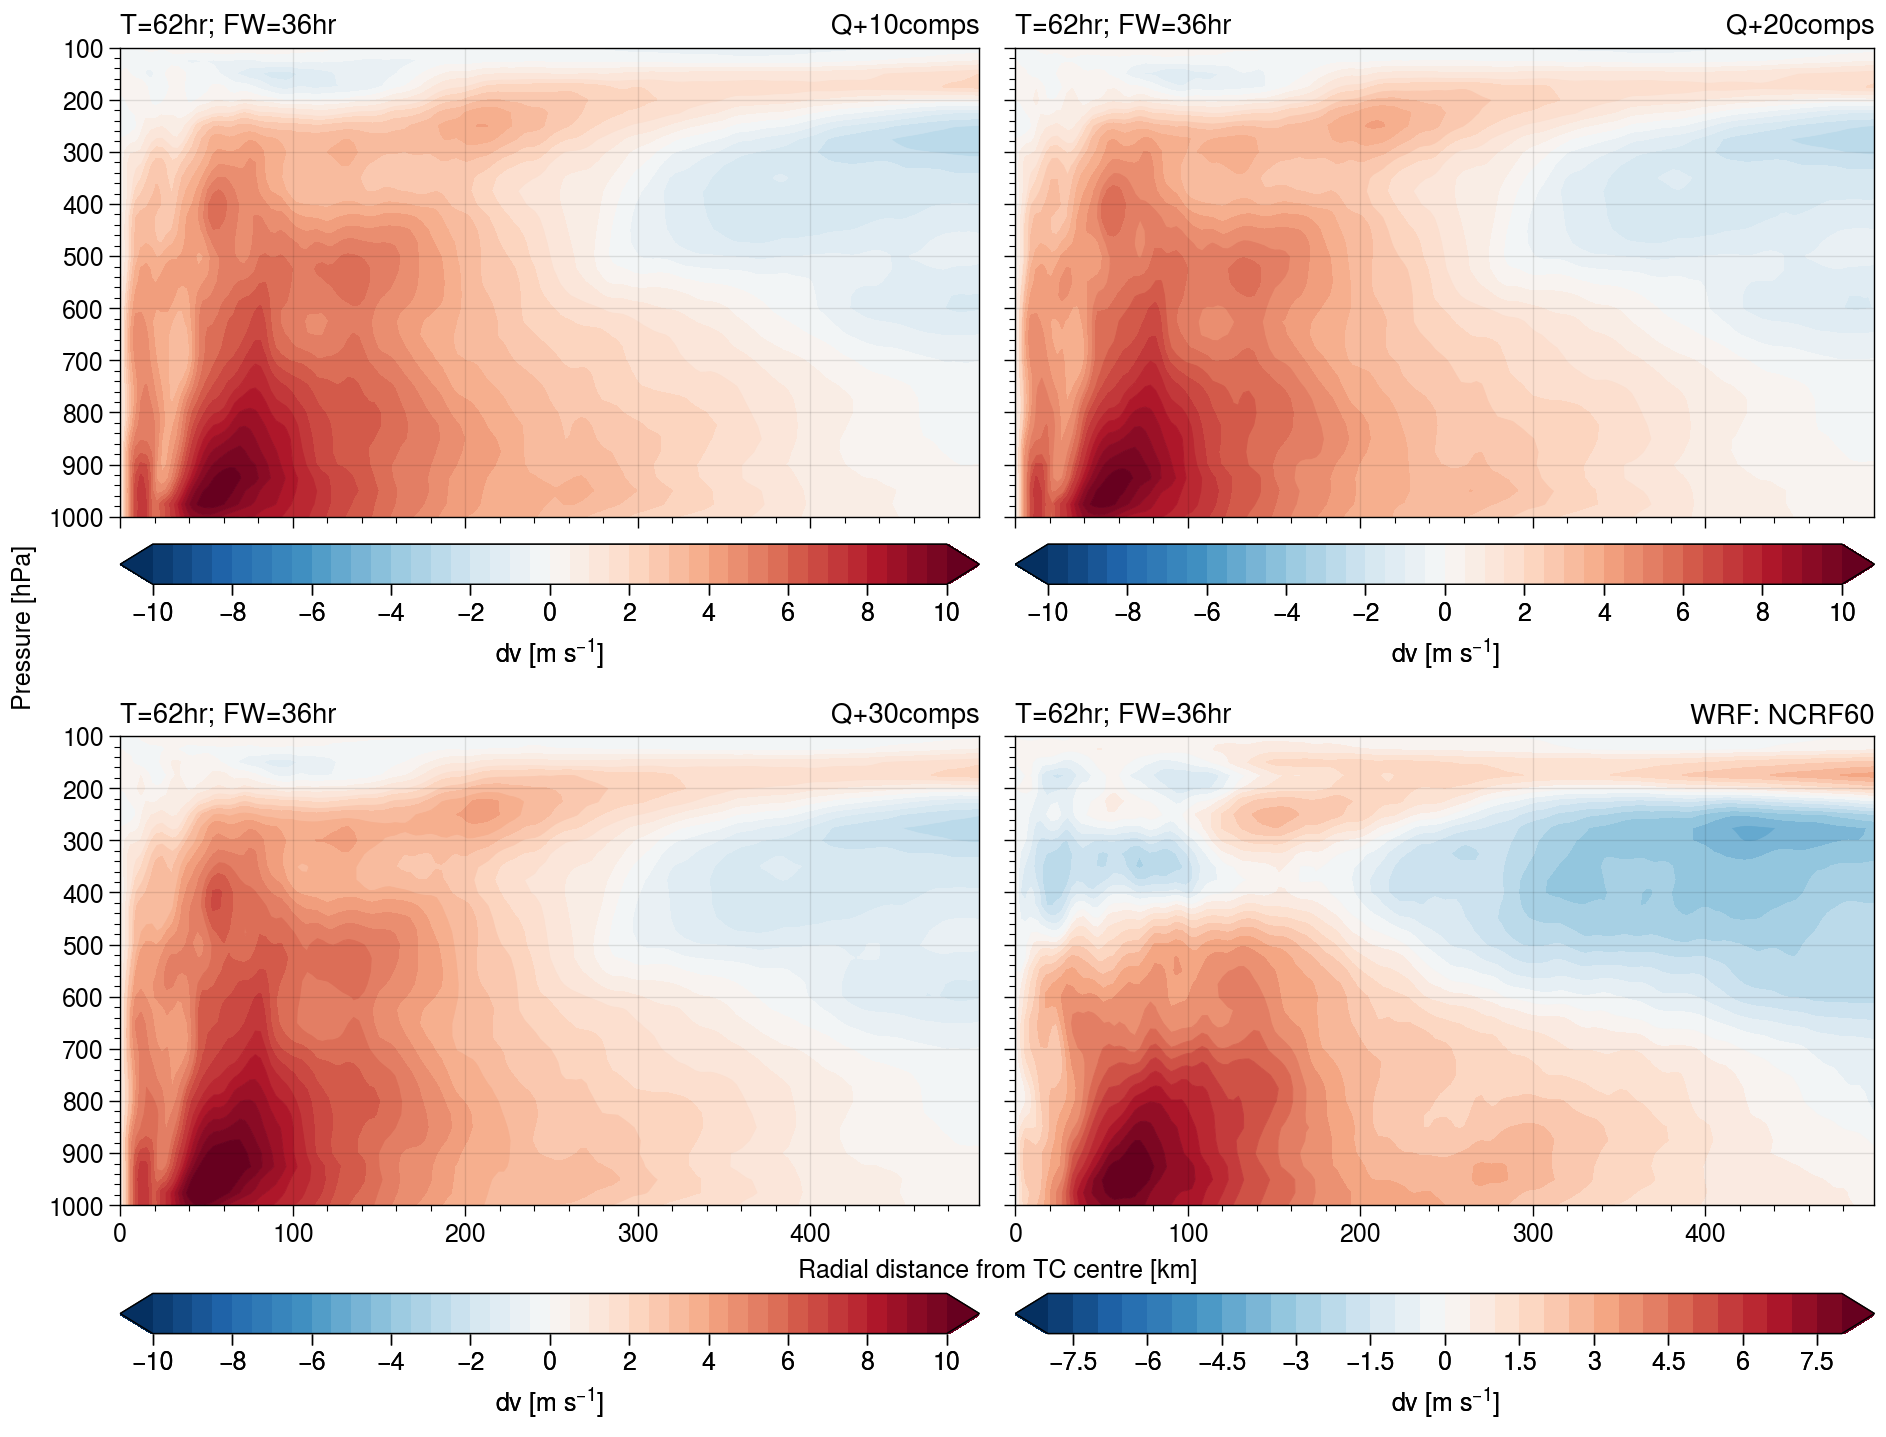

In [12]:
var='v'
if var=='v':
    clv = np.linspace(-8,8,33) #np.linspace(-10,10,41)
elif var=='u':
    clv = np.linspace(-3,3,31)
    
fig,axs = plot.subplots(ncols=2,nrows=2,axwidth=4.295,refaspect=1.831)
mapp = axs[0].contourf(np.linspace(0,166,167)*3,coorpres,np.nanmean(RECONir3_dict['d'+str(var)][5],axis=(1))*(36*60*60),cmap='RdBu_r',levels=np.linspace(-10,10,41),shading='auto',extend='both')
axs[0].format(ylim=[1000,100],xlabel='Radial distance from TC centre [km]',ylabel='Pressure [hPa]',rtitle=r'Q+10comps',ltitle='T=62hr; FW=36hr') #-$\theta$-u-v-w
axs[0].colorbar(mapp,loc='b',label='d'+str(var)+' [m s$^{-1}$]')

mapp = axs[1].contourf(np.linspace(0,166,167)*3,coorpres,np.nanmean(RECONir2_dict['d'+str(var)][5],axis=(1))*(36*60*60),cmap='RdBu_r',levels=np.linspace(-10,10,41),shading='auto',extend='both')
axs[1].format(ylim=[1000,100],xlabel='Radial distance from TC centre [km]',ylabel='Pressure [hPa]',rtitle=r'Q+20comps',ltitle='T=62hr; FW=36hr') #-$\theta$-u-v-w
axs[1].colorbar(mapp,loc='b',label='d'+str(var)+' [m s$^{-1}$]')

mapp = axs[2].contourf(np.linspace(0,166,167)*3,coorpres,np.nanmean(RECONir_dict['d'+str(var)][5],axis=(1))*(36*60*60),cmap='RdBu_r',levels=np.linspace(-10,10,41),shading='auto',extend='both')
axs[2].format(ylim=[1000,100],xlabel='Radial distance from TC centre [km]',ylabel='Pressure [hPa]',rtitle=r'Q+30comps',ltitle='T=62hr; FW=36hr') #-$\theta$-u-v-w
axs[2].colorbar(mapp,loc='b',label='d'+str(var)+' [m s$^{-1}$]')

mapp=axs[3].contourf(np.linspace(0,166,167)*3,coorpres,np.nanmean(ncrf60_dv[5],axis=(1)),cmap='RdBu_r',levels=clv,shading='auto',extend='both')
axs[3].format(ylim=[1000,100],xlabel='Radial distance from TC centre [km]',ylabel='Pressure [hPa]',rtitle=r'WRF: NCRF60',ltitle='T=62hr; FW=36hr')
axs[3].colorbar(mapp,loc='b',label='d'+str(var)+' [m s$^{-1}$]')
plt.savefig('./figures/0316/aximean_d'+str(var)+'_Q_addFFW.png',dpi=300)
plt.show()

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/proplot/axes/plot.py:1275: UserWarning: The following kwargs were not used by contour: 'shading'
  obj = getattr(super(), name)(*args, **kwargs)
/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/proplot/axes/plot.py:1275: UserWarning: The following kwargs were not used by contour: 'shading'
  obj = getattr(super(), name)(*args, **kwargs)
/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/proplot/axes/plot.py:1275: UserWarning: The following kwargs were not used by contour: 'shading'
  obj = getattr(super(), name)(*args, **kwargs)
/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/proplot/axes/plot.py:1275: UserWarning: The following kwargs were not used by contour: 'shading'
  obj = getattr(super(), name)(*args, **kwar

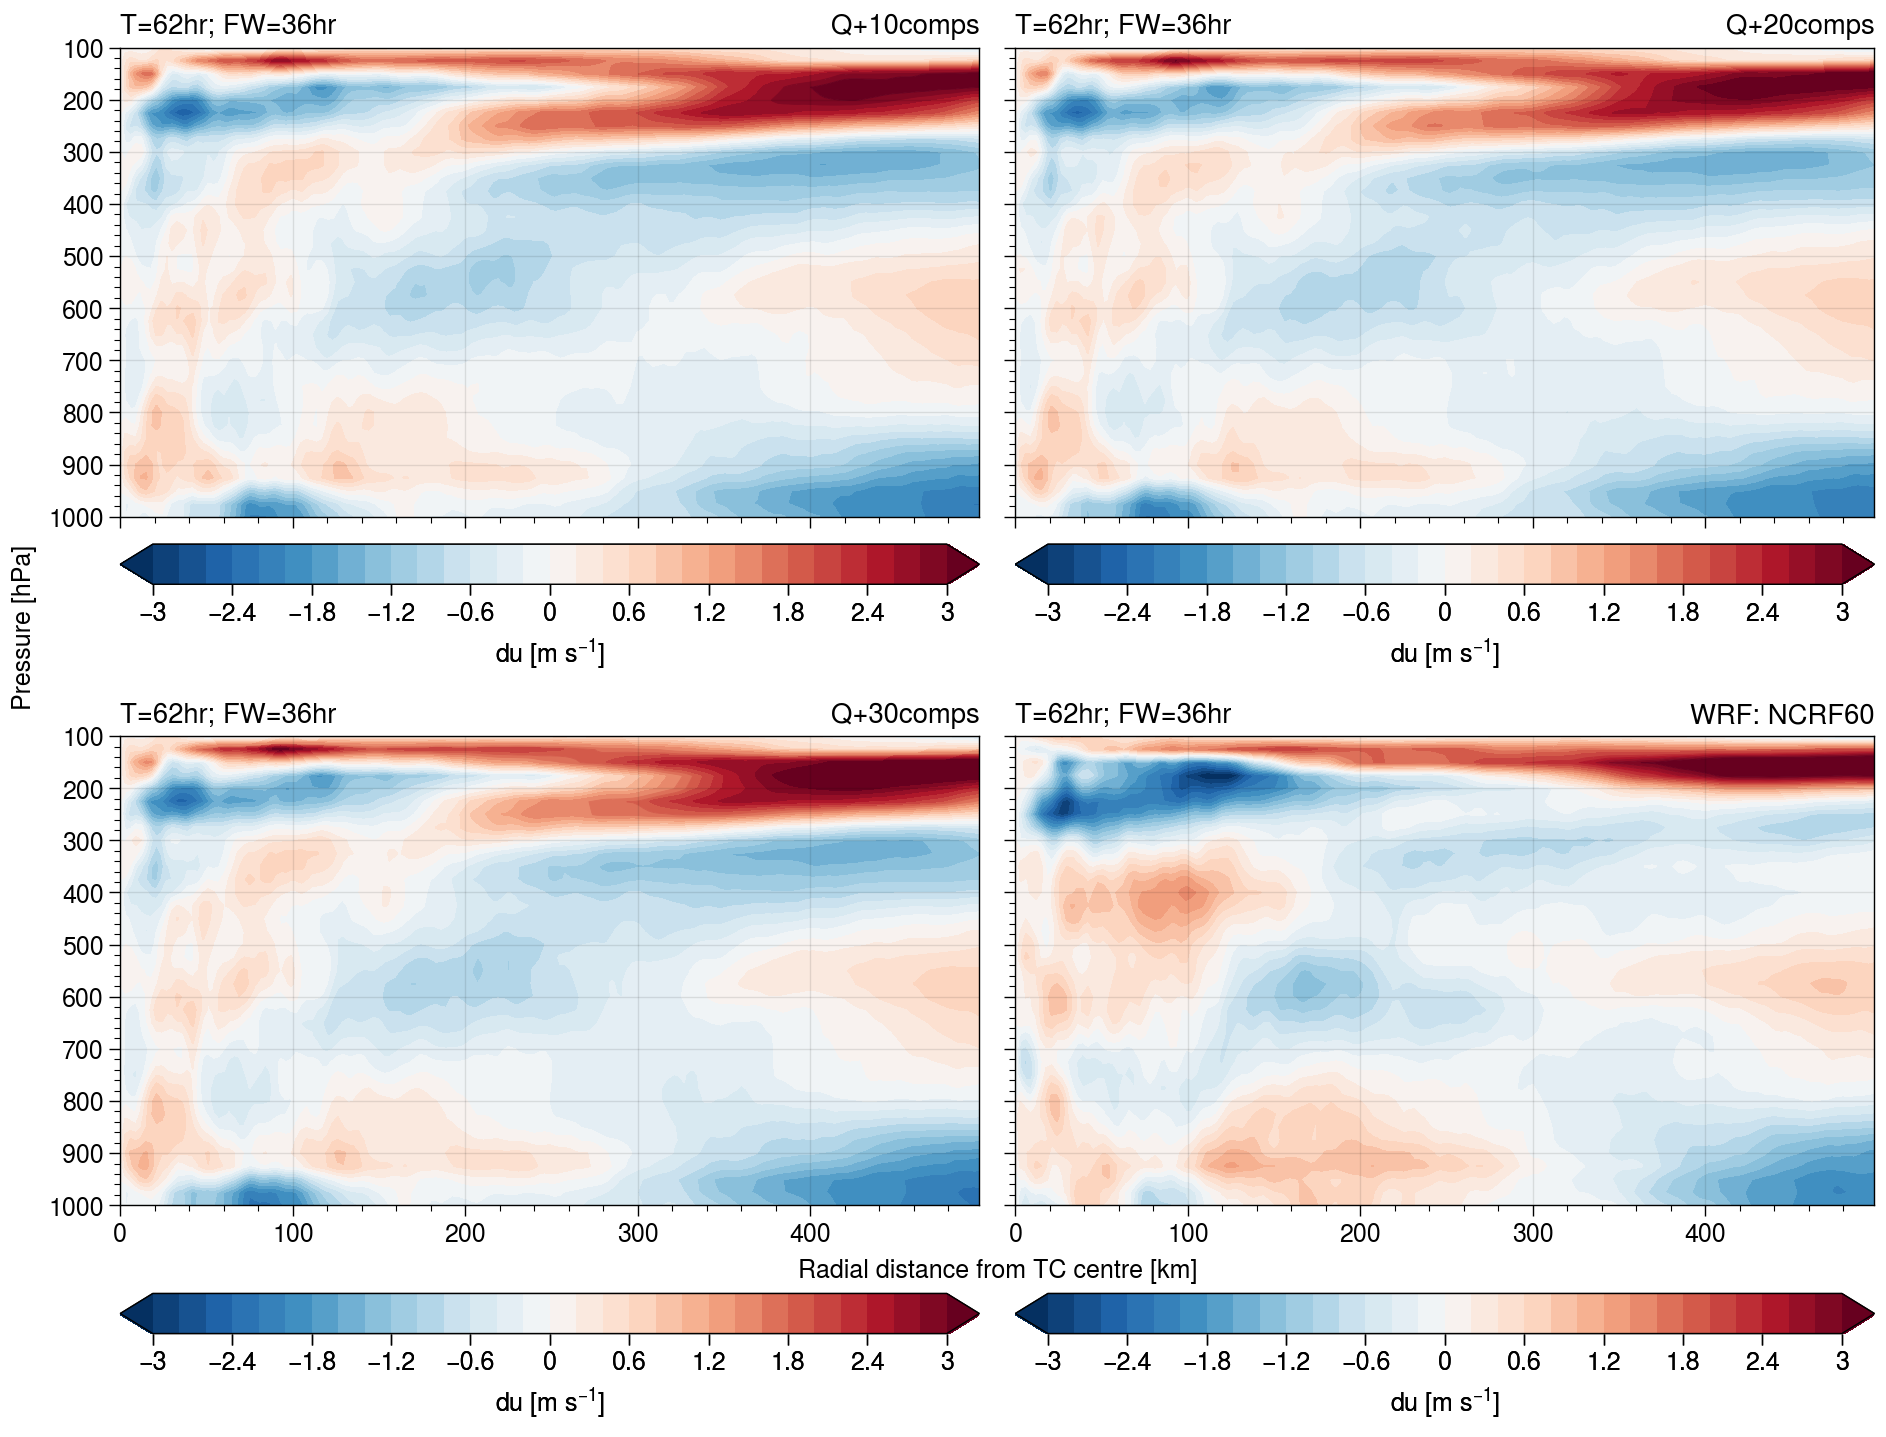

In [20]:
var='u'
if var=='v':
    clv = np.linspace(-8,8,33) #np.linspace(-10,10,41)
elif var=='u':
    clv = np.linspace(-3,3,31)
    
fig,axs = plot.subplots(ncols=2,nrows=2,axwidth=4.295,refaspect=1.831)
mapp = axs[0].contourf(np.linspace(0,166,167)*3,coorpres,np.nanmean(RECONir3_dict['d'+str(var)][5],axis=(1))*(36*60*60),cmap='RdBu_r',levels=clv,shading='auto',extend='both')
axs[0].format(ylim=[1000,100],xlabel='Radial distance from TC centre [km]',ylabel='Pressure [hPa]',rtitle=r'Q+10comps',ltitle='T=62hr; FW=36hr') #-$\theta$-u-v-w
axs[0].colorbar(mapp,loc='b',label='d'+str(var)+' [m s$^{-1}$]')

mapp = axs[1].contourf(np.linspace(0,166,167)*3,coorpres,np.nanmean(RECONir2_dict['d'+str(var)][5],axis=(1))*(36*60*60),cmap='RdBu_r',levels=clv,shading='auto',extend='both')
axs[1].format(ylim=[1000,100],xlabel='Radial distance from TC centre [km]',ylabel='Pressure [hPa]',rtitle=r'Q+20comps',ltitle='T=62hr; FW=36hr') #-$\theta$-u-v-w
axs[1].colorbar(mapp,loc='b',label='d'+str(var)+' [m s$^{-1}$]')

mapp = axs[2].contourf(np.linspace(0,166,167)*3,coorpres,np.nanmean(RECONir_dict['d'+str(var)][5],axis=(1))*(36*60*60),cmap='RdBu_r',levels=clv,shading='auto',extend='both')
axs[2].format(ylim=[1000,100],xlabel='Radial distance from TC centre [km]',ylabel='Pressure [hPa]',rtitle=r'Q+30comps',ltitle='T=62hr; FW=36hr') #-$\theta$-u-v-w
axs[2].colorbar(mapp,loc='b',label='d'+str(var)+' [m s$^{-1}$]')

mapp=axs[3].contourf(np.linspace(0,166,167)*3,coorpres,np.nanmean(ncrf60_du[5],axis=(1)),cmap='RdBu_r',levels=clv,shading='auto',extend='both')
axs[3].format(ylim=[1000,100],xlabel='Radial distance from TC centre [km]',ylabel='Pressure [hPa]',rtitle=r'WRF: NCRF60',ltitle='T=62hr; FW=36hr')
axs[3].colorbar(mapp,loc='b',label='d'+str(var)+' [m s$^{-1}$]')
plt.savefig('./figures/0316/aximean_d'+str(var)+'_Q_addFFW.png',dpi=300)
plt.show()

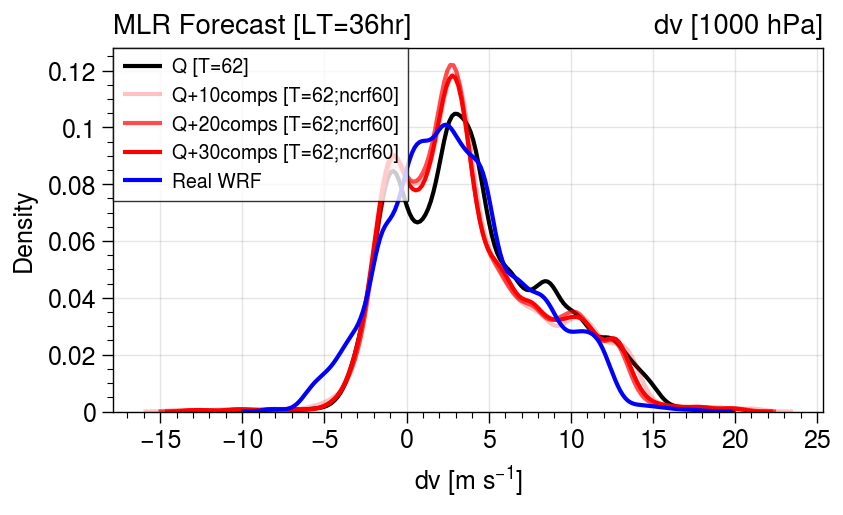

In [16]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.55,refaspect=1.951,sharey=3,sharex=0)
sns.kdeplot((RECONq_dict['dv'][5][0,:,:]*(36*60*60)).flatten(),ax=axs[0],c='k',label='Q [T=62]')#,cumulative=True)
sns.kdeplot((RECONir3_dict['dv'][5][0,:,:]*(36*60*60)).flatten(),ax=axs[0],c='r',alpha=0.24,label='Q+10comps [T=62;ncrf60]')#,cumulative=True)
sns.kdeplot((RECONir2_dict['dv'][5][0,:,:]*(36*60*60)).flatten(),ax=axs[0],c='r',alpha=0.7,label='Q+20comps [T=62;ncrf60]')#,cumulative=True)
sns.kdeplot((RECONir_dict['dv'][5][0,:,:]*(36*60*60)).flatten(),ax=axs[0],c='r',label='Q+30comps [T=62;ncrf60]')#,cumulative=True)
sns.kdeplot((ncrf60_dv[5][0,:,:]).flatten(),ax=axs[0],c='b',label='Real WRF')#,cumulative=True)
axs[0].legend(loc='ul',ncols=1,prop={'size':7})
axs[0].format(xlabel='dv [m s$^{-1}$]',ltitle='MLR Forecast [LT=36hr]',rtitle='dv [1000 hPa]')
plt.savefig('./figures/0316/dv1000_30pdf.png',dpi=300)
plt.show()

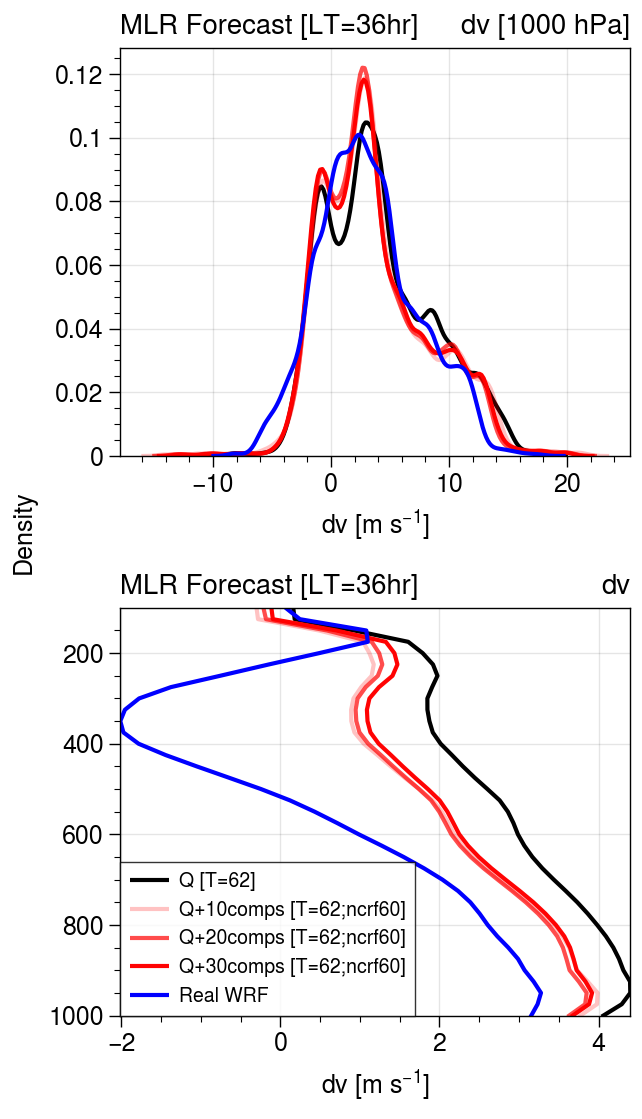

In [18]:
fig,axs = plot.subplots(ncols=1,nrows=2,axwidth=2.55,refaspect=1.251,sharey=3,sharex=0)
sns.kdeplot((RECONq_dict['dv'][5][0,:,:]*(36*60*60)).flatten(),ax=axs[0],c='k',label='Q [T=62]')#,cumulative=True)
sns.kdeplot((RECONir3_dict['dv'][5][0,:,:]*(36*60*60)).flatten(),ax=axs[0],c='r',alpha=0.24,label='Q+10comps [T=62;ncrf60]')#,cumulative=True)
sns.kdeplot((RECONir2_dict['dv'][5][0,:,:]*(36*60*60)).flatten(),ax=axs[0],c='r',alpha=0.70,label='Q+20comps [T=62;ncrf60]')#,cumulative=True)
sns.kdeplot((RECONir_dict['dv'][5][0,:,:]*(36*60*60)).flatten(),ax=axs[0],c='r',label='Q+30comps [T=62;ncrf60]')#,cumulative=True)
sns.kdeplot((ncrf60_dv[5][0,:,:]).flatten(),ax=axs[0],c='b',label='Real WRF')#,cumulative=True)
#axs[0].legend(loc='ul',ncols=1,prop={'size':7})
axs[0].format(xlabel='dv [m s$^{-1}$]',ltitle='MLR Forecast [LT=36hr]',rtitle='dv [1000 hPa]')
#plt.savefig('./figures/0308/dv1000_30pdf.png',dpi=300)

axs[1].plot((np.nanmean(RECONq_dict['dv'][5]*(36*60*60),axis=(1,2))),coorpres,c='k',label='Q [T=62]')
axs[1].plot((np.nanmean(RECONir3_dict['dv'][5]*(36*60*60),axis=(1,2))),coorpres,c='r',alpha=0.24,label='Q+10comps [T=62;ncrf60]')
axs[1].plot((np.nanmean(RECONir2_dict['dv'][5]*(36*60*60),axis=(1,2))),coorpres,c='r',alpha=0.70,label='Q+20comps [T=62;ncrf60]')
axs[1].plot((np.nanmean(RECONir_dict['dv'][5]*(36*60*60),axis=(1,2))),coorpres,c='r',alpha=0.99,label='Q+30comps [T=62;ncrf60]')
axs[1].plot((np.nanmean(ncrf60_dv[5],axis=(1,2))),coorpres,c='b',label='Real WRF')
axs[1].legend(loc='ll',ncols=1,prop={'size':7})
axs[1].format(ylim=[1000,100],xlabel='dv [m s$^{-1}$]',ylabel='Pressure (hPa)',ltitle='MLR Forecast [LT=36hr]',rtitle='dv')
plt.savefig('./figures/0316/windsPDF_cross_FFS.png',dpi=300)
plt.show()

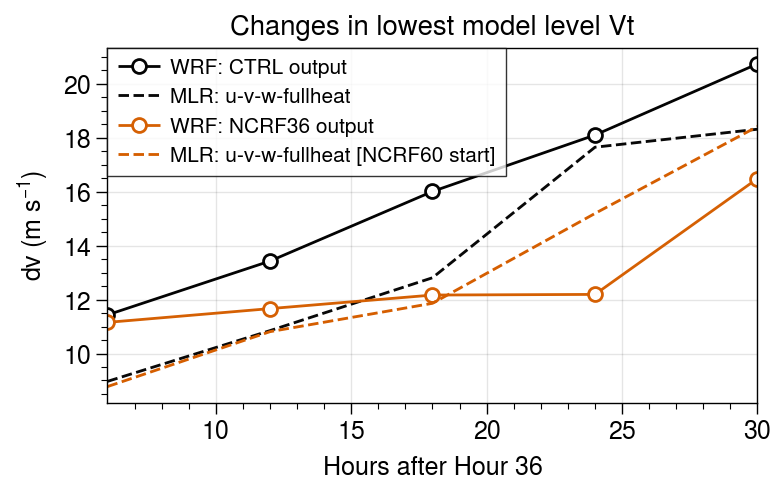

In [78]:
modeltime = [6,12,18,24,30]
var = 'v'
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.25,refaspect=1.831)
axs[0].plot(modeltime,wspd[:-2],marker='o',markersize=5,mec='k',mew=1,mfc='w',c='k',lw=1,alpha=0.99,label='WRF: CTRL output')
axs[0].plot(modeltime,[np.nanmax(validate_mlr(RECONctl_dict,modeltime).surfacewspd_mlr()[i][:,:]) for i in range(len(modeltime))],\
            label='MLR: u-v-w-fullheat',c='k',lw=1.02,alpha=0.97,ls='--')
axs[0].plot(modeltime,wspd60[:-2],marker='o',markersize=5,mec='C1',mew=1,mfc='w',c='C1',lw=1,alpha=0.99,label='WRF: NCRF36 output')
axs[0].plot(modeltime,[np.nanmax(validate_mlr(RECONncrf60_dict,modeltime).surfacewspd_mlr()[i][:,:]) for i in range(len(modeltime))],\
            label='MLR: u-v-w-fullheat [NCRF60 start]',c='C1',lw=1.02,ls='--')
#axs[0].plot([3,6,9,12,15,18,21,24,27,30,33,36,39,42,45],\
#            [np.nanmean(np.nanmean(validate_mlr(RECONall60_noirdict,modeltime).surfacev_mlr()[i][:,:],axis=0)) for i in range(15)],\
#            label='MLR: u-v-w-resi heat',c='m',lw=1.02,ls='--')
#axs[0].plot([3,6,9,12,15,18,21,24,27,30,33,36,39,42,45],[np.max(np.nanmean(testintd[i][:,:],axis=0)) for i in range(15)],label='MLR: u-v-w-resi heat [NCRF36 start]',c='b',lw=1.02,ls='--')


axs[0].legend(loc='ul',ncols=1,prop={'size':7.5})
axs[0].format(ylabel='dv (m s$^{-1}$)',xlabel='Hours after Hour 36',title='Changes in lowest model level Vt')
#plt.savefig('./proc_fig/0207/d'+str(var)+'_trackintensity60_new_doesnotwork3.png',dpi=400)
plt.show()

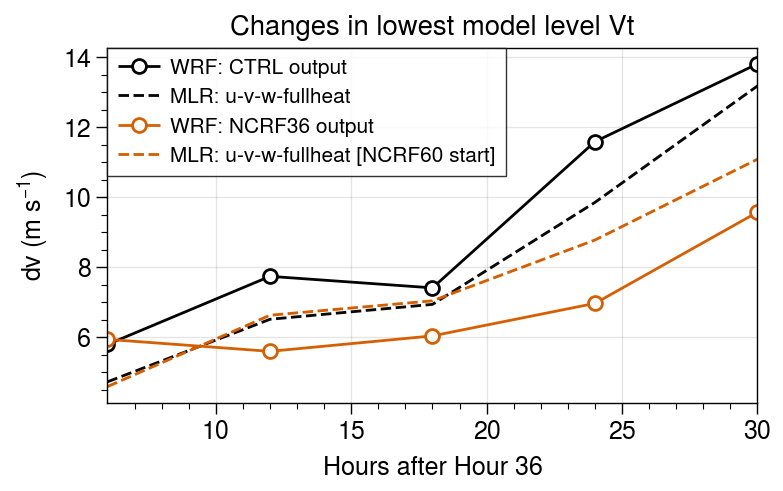

In [31]:
modeltime = [6,12,18,24,30]
var = 'v'
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.25,refaspect=1.831)
axs[0].plot(modeltime,wspd[:-2],marker='o',markersize=5,mec='k',mew=1,mfc='w',c='k',lw=1,alpha=0.99,label='WRF: CTRL output')
axs[0].plot(modeltime,[np.nanmax(np.nanmean(validate_mlr(RECONctl_dict,modeltime).surfacewspd_mlr()[i][:,:],axis=0)) for i in range(len(modeltime))],\
            label='MLR: u-v-w-fullheat',c='k',lw=1.02,alpha=0.97,ls='--')
axs[0].plot(modeltime,wspd60[:-2],marker='o',markersize=5,mec='C1',mew=1,mfc='w',c='C1',lw=1,alpha=0.99,label='WRF: NCRF36 output')
axs[0].plot(modeltime,[np.nanmax(np.nanmean(validate_mlr(RECONncrf60_dict,modeltime).surfacewspd_mlr()[i][:,:],axis=0)) for i in range(len(modeltime))],\
            label='MLR: u-v-w-fullheat [NCRF60 start]',c='C1',lw=1.02,ls='--')
#axs[0].plot([3,6,9,12,15,18,21,24,27,30,33,36,39,42,45],\
#            [np.nanmean(np.nanmean(validate_mlr(RECONall60_noirdict,modeltime).surfacev_mlr()[i][:,:],axis=0)) for i in range(15)],\
#            label='MLR: u-v-w-resi heat',c='m',lw=1.02,ls='--')
#axs[0].plot([3,6,9,12,15,18,21,24,27,30,33,36,39,42,45],[np.max(np.nanmean(testintd[i][:,:],axis=0)) for i in range(15)],label='MLR: u-v-w-resi heat [NCRF36 start]',c='b',lw=1.02,ls='--')


axs[0].legend(loc='ul',ncols=1,prop={'size':7.5})
axs[0].format(ylabel='dv (m s$^{-1}$)',xlabel='Hours after Hour 36',title='Changes in lowest model level Vt')
#plt.savefig('./proc_fig/0207/d'+str(var)+'_trackintensity60_new_doesnotwork3.png',dpi=400)
plt.show()

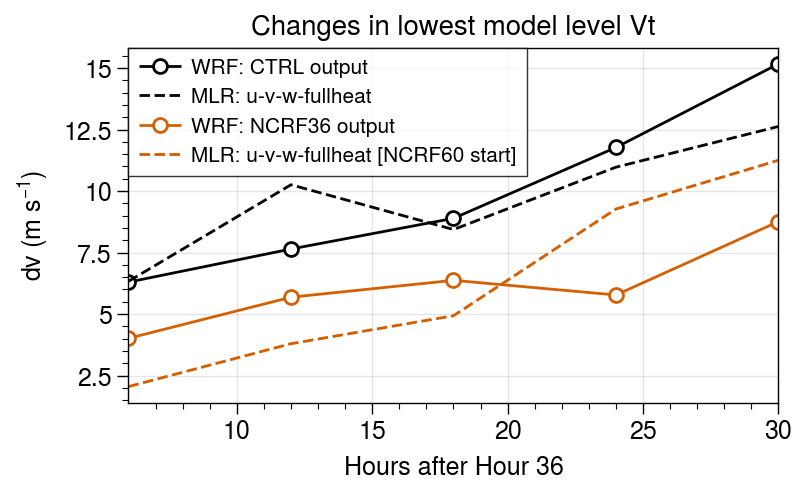

In [61]:
modeltime = [6,12,18,24,30]
var = 'v'
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.25,refaspect=1.831)
axs[0].plot(modeltime,wspd[:],marker='o',markersize=5,mec='k',mew=1,mfc='w',c='k',lw=1,alpha=0.99,label='WRF: CTRL output')
axs[0].plot(modeltime,[np.nanmax(np.nanmean(validate_mlr(RECONctl_dict,modeltime).surfacewspd_mlr()[i][:,:],axis=0)) for i in range(len(modeltime))],\
            label='MLR: u-v-w-fullheat',c='k',lw=1.02,alpha=0.97,ls='--')
axs[0].plot(modeltime,wspd60[:],marker='o',markersize=5,mec='C1',mew=1,mfc='w',c='C1',lw=1,alpha=0.99,label='WRF: NCRF36 output')
axs[0].plot(modeltime,[np.nanmax(np.nanmean(validate_mlr(RECONncrf60_dict,modeltime).surfacewspd_mlr()[i][:,:],axis=0)) for i in range(len(modeltime))],\
            label='MLR: u-v-w-fullheat [NCRF60 start]',c='C1',lw=1.02,ls='--')
#axs[0].plot([3,6,9,12,15,18,21,24,27,30,33,36,39,42,45],\
#            [np.nanmean(np.nanmean(validate_mlr(RECONall60_noirdict,modeltime).surfacev_mlr()[i][:,:],axis=0)) for i in range(15)],\
#            label='MLR: u-v-w-resi heat',c='m',lw=1.02,ls='--')
#axs[0].plot([3,6,9,12,15,18,21,24,27,30,33,36,39,42,45],[np.max(np.nanmean(testintd[i][:,:],axis=0)) for i in range(15)],label='MLR: u-v-w-resi heat [NCRF36 start]',c='b',lw=1.02,ls='--')


axs[0].legend(loc='ul',ncols=1,prop={'size':7.5})
axs[0].format(ylabel='dv (m s$^{-1}$)',xlabel='Hours after Hour 36',title='Changes in lowest model level Vt')
#plt.savefig('./proc_fig/0207/d'+str(var)+'_trackintensity60_new_doesnotwork3.png',dpi=400)
plt.show()

#### R2 score

In [12]:
import importlib
importlib.reload(proc_mlrfcst)

<module 'tools.mlr.proc_mlrfcst' from '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/tools/mlr/proc_mlrfcst.py'>

In [13]:
LDTME = [24]#[3,6,9,12,15,18,21,24,27,30,33,36]#,39,42,45]
numcomp = [54,26,50,75]#[22,8,35,19]#[12,3,26,3]#[36,16,44,6]
for obj in [0,1,2,3,4,5,6]:
    r2 = proc_mlrfcst.retrieve_cartesian(PCA_dict=PCAdict,Af_dict=vardicts,numcomp=numcomp,LT=LDTME,
                            forecastPC=forecastPC[obj]).recon_R2_from_linear(saveloc='./output/rscore/Q/Q95/surface/rscore_dtthuvw_complex_'+exp[obj],TEST='real',target='surface')

0.7113437472639769
0.7777799549169186
0.7802411535736027
0.7809388933616978
0.7809388933617265
0.7797651749927267
0.7758832049252764


In [21]:
rscoreloc_all = ['./output/rscore/more/rscore_dtthuvw_dt','./output/rscore/Q/Q95/rscore_dtthuvw_dt','./output/rscore/Q/Q97/rscore_dtthuvw_dt','./output/rscore/Q/Q98/rscore_dtthuvw_dt','./output/rscore/Q/Q99/rscore_dtthuvw_dt']
rscoreloc_surf = ['./output/rscore/Q/Q95/surface/rscore_dtthuvw_dt','./output/rscore/Q/Q97/surface/rscore_dtthuvw_dt','./output/rscore/Q/Q98/surface/rscore_dtthuvw_dt','./output/rscore/Q/Q99/surface/rscore_dtthuvw_dt']
rscoreobj = [read_and_proc.depickle(obj) for obj in rscoreloc_all]
rscoreobj_surf = [read_and_proc.depickle(obj) for obj in rscoreloc_surf]
#sorted(glob.glob('./output/rscore/more/*'))]
#rscoreobj = [read_and_proc.depickle(obj) for obj in sorted(glob.glob('./output/rscore/more/*'))]

In [31]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [26]:
rall = [rscoreobj[0][7],rscoreobj[1][3],rscoreobj[2][0],rscoreobj[3][0],rscoreobj[4][0]]
rsurf = [np.nan,rscoreobj_surf[0][0],rscoreobj_surf[1][0],rscoreobj_surf[2][0],rscoreobj_surf[3][0]]

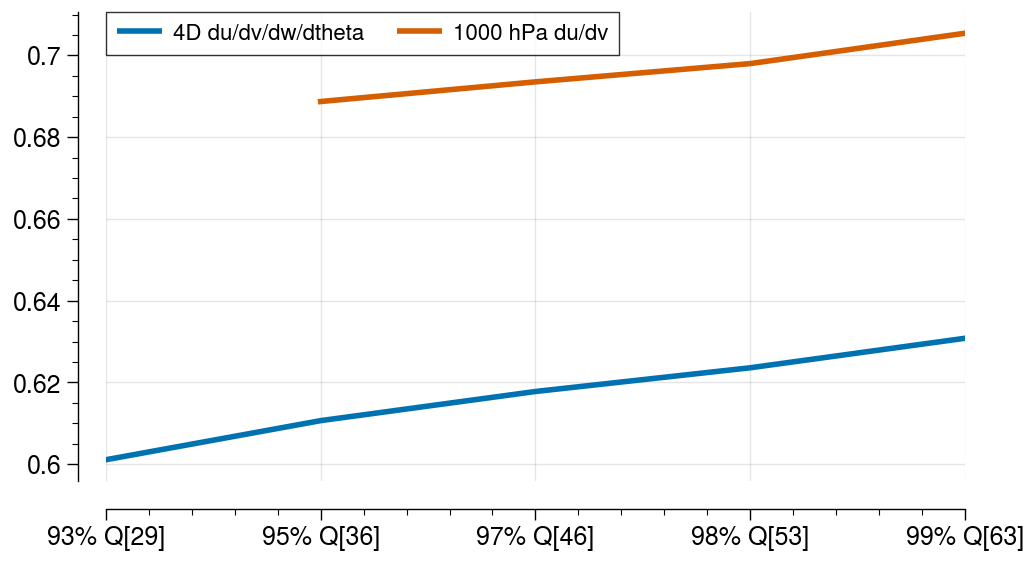

In [41]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
labels = ['93% Q[29]','95% Q[36]','97% Q[46]','98% Q[53]','99% Q[63]']
axs[0].plot(rall,label='4D du/dv/dw/dtheta',lw=2)
axs[0].plot(rsurf,label='1000 hPa du/dv',lw=2)
adjust_spines(axs[0], ['left', 'bottom'])
axs.legend(loc='ul',prop={'size':8},ncols=2)
axs[0].format(xticks=[0,1,2,3,4],xticklabels=labels)
#plt.savefig('./figures/0308/r2_noFFS_more.png',dpi=300)
plt.savefig('./figures/0308/r2_Qincrease.png',dpi=300)
plt.show()

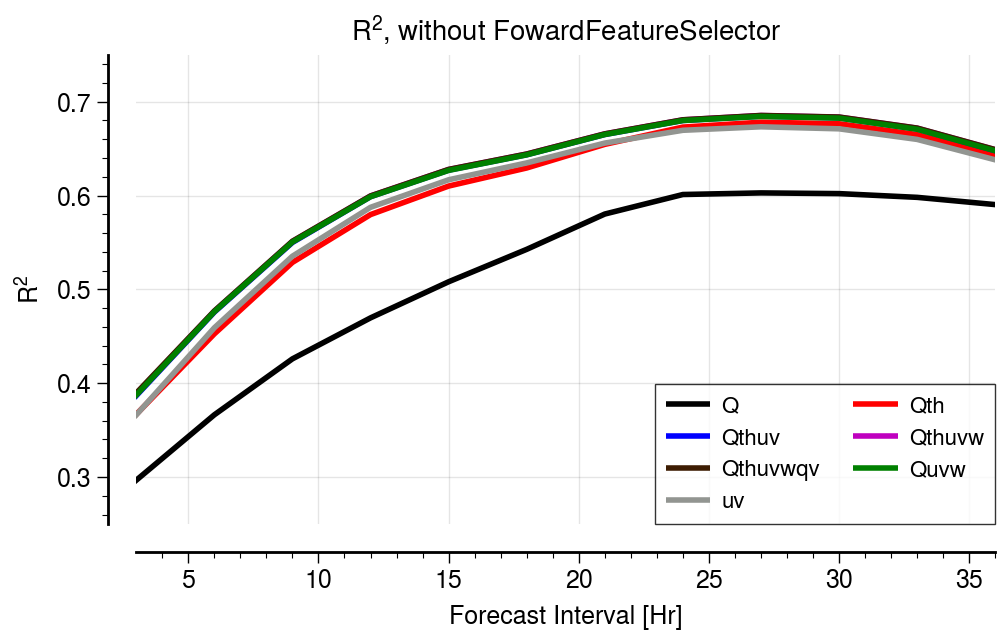

In [27]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
labels = ['Q','Qth','Qthuv','Qthuvw','Qthuvwqv','Quvw','uv']
for indx,obj in enumerate(['k','r','b','m','chocolate','green','gray']):
    axs[0].plot([3,6,9,12,15,18,21,24,27,30,33,36],rscoreobj[indx],color=obj,lw=2,label=labels[indx])
axs[0].format(title=r'R$^{2}$, without FowardFeatureSelector',xlabel='Forecast Interval [Hr]',ylabel=r'R$^{2}$',ylim=[0.25,0.75])
[x.set_linewidth(1.01) for x in axs[0].spines.values()]
adjust_spines(axs[0], ['left', 'bottom'])
axs.legend(loc='lr',prop={'size':8},ncols=2)
plt.savefig('./figures/0308/r2_noFFS_more.png',dpi=300)
plt.show()

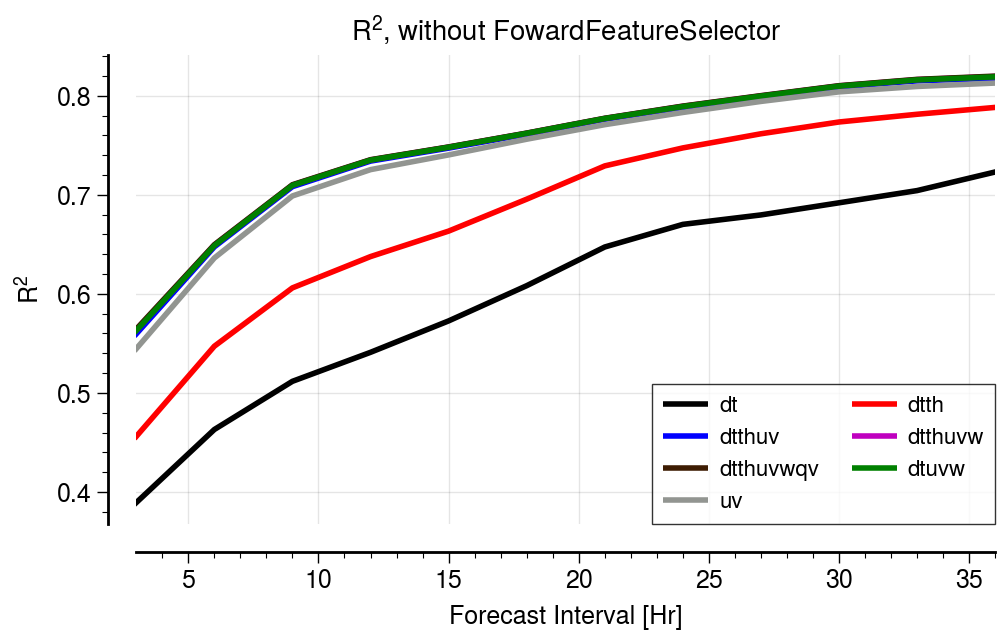

In [34]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
labels = ['dt','dtth','dtthuv','dtthuvw','dtthuvwqv','dtuvw','uv']
for indx,obj in enumerate(['k','r','b','m','chocolate','green','gray']):
    axs[0].plot([3,6,9,12,15,18,21,24,27,30,33,36],rscoreobj[indx],color=obj,lw=2,label=labels[indx])
axs[0].format(title=r'R$^{2}$, without FowardFeatureSelector',xlabel='Forecast Interval [Hr]',ylabel=r'R$^{2}$')
[x.set_linewidth(1.01) for x in axs[0].spines.values()]
adjust_spines(axs[0], ['left', 'bottom'])
axs.legend(loc='lr',prop={'size':8},ncols=2)
plt.savefig('./figures/0308/r2_noFFS.png',dpi=200)
plt.show()

#### ForwardFeatureSelector

In [ ]:
from sklearn.feature_selection import SelectorMixin
from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone
from sklearn.model_selection import cross_val_score
import numpy as np

class forwardfeatureadder(BaseEstimator,SelectorMixin,MetaEstimatorMixin):
    """Transformer to add feature at a sequential order
    Parameters:
    estimator: Regression model
    n_features_to_select: number of features to add to the model
    cv: how many folds would we want during cross-validation
    n_jobs: Parallelization
    startfeatures: Features we would like to include in the model without cross-validation [we do this to accentuate the role of heating]
    
    Output:
    self instance
    """
    def __init__(self,estimator,n_features_to_select=None,cv=5,n_jobs=None,startfeatures=None):
        self.estimator = estimator
        self.n_features_to_select = n_features_to_select
        self.cv = cv
        self.n_jobs = n_jobs
        self.startfeatures = startfeatures
        
    def fit(self, X,y=None):
        """Learn features to select from X.
        X (n_samples,n_features): Training vectors
        Y (n_samples): Target values
        """
        # Define basic settings
        n_features = X.shape[1]
        current_mask = np.zeros(shape=n_features,dtype=bool)
        for index in self.startfeatures:
            current_mask[index] = True
        n_iteractions = self.n_features_to_select
        
        # Do forward selection
        addinput = []
        clone_estimator = clone(self.estimator)
        for _ in range(n_iteractions):
            new_feature_idx = self.get_best_new_feature_R2based(clone_estimator,X,y,current_mask)
            current_mask[new_feature_idx] = True
            addinput.append(current_mask)
        self.support_ = current_mask
        self.new_feature = new_feature_idx
        return self
    
    def get_best_new_feature(self,estimator,X,y,current_mask):
        candidate_feature_indices = np.flatnonzero(~current_mask)
        scores={}
        for feature_idx in candidate_feature_indices:
            candidate_mask = current_mask.copy()
            candidate_mask[feature_idx] = True
            
            # Add a new feature
            X_new = X[:,candidate_mask]
            # Improvement
            scores[feature_idx] = cross_val_score(estimator,X_new,y,cv=self.cv,scoring=None,n_jobs=self.n_jobs).mean()
        return max(scores,key=lambda feature_idx: scores[feature_idx])
    
    #--------------------------------------------------------------
    # To do -> Add featureselector based on r2
    # Candidate mask -> Xnew
    # fit linear model with (Xnew,y)
    # {output r2 term [time consideration => target: surface u/v]}...repeat for all u/v/w/theta members
    # get component index that results in best r2 score
    # --------[[Exit loops when r2 reaches 0.75?]]-----------------
    # add to mask during fitting 
    #---------------------------------------------------------------------------------------------------
    def get_WRFreal(self,LT=None):
        
    def get_best_new_feature_R2based(self,estimator,X,y,current_mask):
        candidate_feature_indices = np.flatnonzero(~current_mask)
        scores={}
        for feature_idx in candidate_feature_indices:
            candidate_mask = current_mask.copy()
            candidate_mask[feature_idx] = True
            # Add a new feature
            X_new = X[:,candidate_mask]
            print(candidate_mask)
            print(X_new.shape)
            print(a)
            # Improvement
            scores[feature_idx] = r2_score(np.concatenate((reteMP1,reteMP2,reteMP3,reteMP4),axis=0),np.concatenate((teMP1,teMP2,teMP3,teMP4),axis=0))
        return max(scores,key=lambda feature_idx: scores[feature_idx])
    
    def _get_support_mask(self):
        return self.support_

##### Train

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/complex/Q95_complex/'
file2 = [path+'inputoutput/'+'inputQ95_dict_smoo6_withtheta',path+'inputoutput/'+'outputQ95_dict_smoo6_withtheta']#,path+'NOIR_dict_smoo6_withtheta',path+'IR_dict_smoo6_withtheta']
mlr_inputdict,mlr_output = read_and_proc.depickle(file2[0]),read_and_proc.depickle(file2[1])

In [7]:
mlr_inputdict['dtthuvw'].shape

(330, 241)

In [ ]:
### ForwardFeatureSelector
# Code structure: (One forecast window at a time)
# for i: 1 - len(totalfeature-heatfeature)
# (a)     seq_temp = forwardfeatureadder().fit(X,y)......................................[Select features with greedy forward selector]; Done
#         important_feature = seq_temp.get_support()
# (b)     Xnew = seq_temp.transform(X)...................................................[Remove unimportant features]; Done
# (c)     ynew = estimator.predict(Xnew).................................................[Make predictions with reduced feature space]
# (d)     upred,vpred,wpred = np.dot(ynew[0:xx],uPCA),np.dot(ynew[xx:xx+yy],vPCA),.......[Conversion between PCA space and cartesian space]
# (e)     R2_score(np.concatenate(ureal,vreal,wreal),np.concatenate(upred,vpred,wpred))..[Performance accuracy]
# (f)     R2_score.append()

# Initiate model
linreg = LinearRegression()
mlrIN,mlrOUT = mlr.SimpleIOhandler(LT=24,auxIN=None).transform(mlr_inputdict['dtthuvw'],mlr_output)
# Train model
model,reducedX,new_feature = [],[],[]
for i in tqdm(range(np.asarray(mlrIN).shape[1]-36)):
    seq_temp = forwardfeatureadder(linreg,i+1,3,2,[int(obj) for obj in np.linspace(241-36,240,36)]).fit(np.asarray(mlrIN),mlrOUT)
    new_feature.append(seq_temp.new_feature)
    Xn = seq_temp.transform(np.asarray(mlrIN)) #Remove unimportant features
    ridge_reduced = LinearRegression().fit(Xn,mlrOUT) #Train model with reduced input
    model.append(ridge_reduced)
    reducedX.append(Xn)
    ####################################################################################################
    # Check r2 score
    ####################################################################################################
    if r2_score(mlrOUT,ridge_reduced.predict(Xn))<=0.9:
        continue
    else:
        break

In [8]:
expname = 'FFSmodel_dtthuvw30'
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/'
read_and_proc.save_to_pickle(folderpath+'pca/output/'+str(expname)+'_'+'smoo6_withtheta',model,'PICKLE')
read_and_proc.save_to_pickle(folderpath+'pca/output/'+'reducedX'+'_'+'smoo6_withtheta',reducedX,'PICKLE')
read_and_proc.save_to_pickle(folderpath+'pca/output/'+'newfeature'+'_'+'smoo6_withtheta',new_feature,'PICKLE')

##### Read

In [12]:
def adjust_spines(ax, spines,outpoint=2):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', outpoint))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])  

In [9]:
r2_list = [r2_score(mlrOUT,models.predict(Xns)) for (models,Xns) in zip(model,reducedX)]

In [10]:
r2_list

[0.6558232433211142,
 0.664536834089188,
 0.6892611180376714,
 0.7000443515576515,
 0.7193646731649754,
 0.7260210560386589,
 0.7327833002582124,
 0.7433182891619514,
 0.7514662756322767,
 0.7590846851507379,
 0.7644036615860333,
 0.7746233033336328,
 0.7795103004849454,
 0.7879264251300145,
 0.7935569626888439,
 0.7996913842605137,
 0.8061952996539878,
 0.8134276818276283,
 0.8224325172336174,
 0.8264585803681463,
 0.8356800215614151,
 0.8382234199239103,
 0.8431420042330717,
 0.8485443823638965,
 0.8544624261751766,
 0.8593932523535508,
 0.8639162580155487,
 0.8654470093425297,
 0.8672364865217932,
 0.8713119538949392,
 0.8732536894601818,
 0.87682359846525,
 0.8800683950964397,
 0.8816921251968083,
 0.8838774878606163,
 0.8882324829365918,
 0.8898646489566137,
 0.8947580432120787,
 0.8964636515049093,
 0.8994694233881996,
 0.9040487807299282]

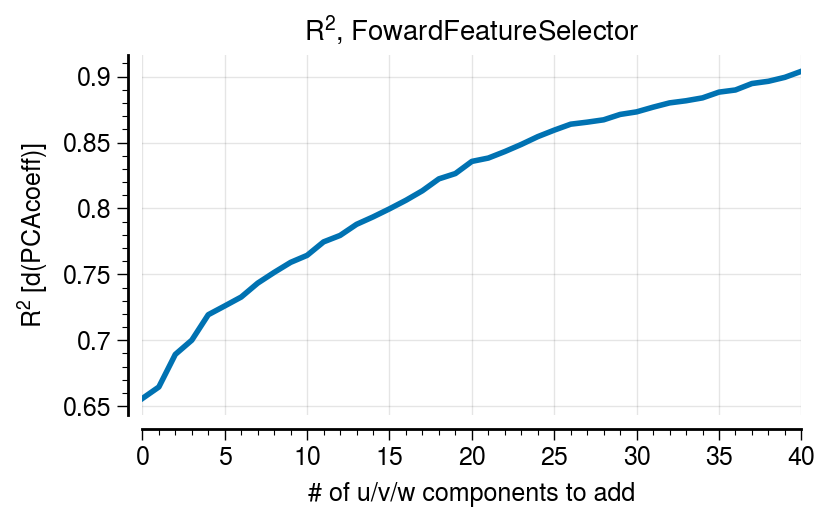

In [13]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.295,refaspect=1.831)
axs[0].plot(r2_list,lw=2)
axs[0].format(title=r'R$^{2}$, FowardFeatureSelector',xlabel='# of u/v/w components to add',ylabel=r'R$^{2}$ [d(PCAcoeff)]')
[x.set_linewidth(1.01) for x in axs[0].spines.values()]
adjust_spines(axs[0], ['left', 'bottom'],5)
#axs.legend(loc='lr',prop={'size':8},ncols=2)
plt.savefig('./figures/0308/r2_FFS_results.png',dpi=200)
plt.show()

In [21]:
new_feature[0:15]

[35, 27, 4, 7, 28, 20, 8, 33, 24, 10, 29, 42, 9, 23, 30]

#### Data check

### Reconstruct - Model Performance

In [65]:
gc.collect()
from copy import deepcopy
# Only dthetadt -12
mlr_input_dtuvw_onlydt = np.zeros_like(mlr_inputdict['dtuvw'])#deepcopy(mlr_inputdict['dtuvw']) #np.zeros_like(mlr_inputdict['dtuvw'])
#mlr_input_dtuvw_onlydt = deepcopy(mlr_inputdict['dtuvw'])
#mlr_input_dtuvw_onlydt[60-24,:22] = mlr_input_dtuvw_onlydt[180,:22]
mlr_input_dtuvw_onlydt[60-24,:-10] = mlr_input_dtuvw_onlydt[180,:-10]
#mlr_input_dtuvw_onlydt[36-24,:] = mlr_input_dtuvw_onlydt[180,:]

#mlr_input_dtuvw_onlydt[0:96,-12:] = 5.7059535e-09
#mlr_input_dtuvw_onlydt[96:179,-12:] = -0.015845174
#mlr_input_dtuvw_onlydt[179:238,-12:] = -0.015845174
#mlr_input_dtuvw_onlydt[238:,-12:] = 0.0032079637
#mlr_input_dtuvw_onlydt[:,0:-12]=mlr_inputdict_aux['dtuvw'][:,0:-12]
#mlr_input_dtuvw_onlydt[:,-12:]=mlr_inputdict_aux2['dtuvw'][:,-12:]
#mlr_input_dtuvw_onlydt[:,-12]=mlr_inputdict['dtuvw'][:,-12:][:,0]
#mlr_input_dtuvw_onlydt[:,-11]=mlr_inputdict['dtuvw'][:,-12:][:,1]

In [67]:
# Test 1: [12,12,15] 85% variances 
# Test 2: [3,3,10] 20% duv, 50% dw
# Test 3: [6,6,10] 50% variance
import gc
import importlib
importlib.reload(mlr)

LDTME = [3,6,9,12,15,18,21,24,27,30,33,36,39,42,45]#[1,3,6,9,12,15,18,21,24]#np.linspace(0,23,24)+1
#nocomp = [3,3,10]
nocomp = [5,5,9]
#nocomp = [8,8,12]
#nocomp = [9,9,13]
#nocomp = [11,11,15]
#nocomp = [14,14,18]

#################################################################################################################
# (a) Output Error and Variability for R^2 calculation (original input)
#forecast_eiginput = output_regpredict(mlr_inputdict['dtuvw'],mlr_output,LDTME,'linear','without',0.001)
#uv_recondict1,uv_recondict2 = recon_from_linear(forecast_eiginput,PCA_dict,LDTME,nocomp)
#dtuvw_recondict1,dtuvw_recondict2 = mlr.recon_from_linear(forecast_eiginput,PCA_dict,LDTME,nocomp,True,\
#                                                         [Af_dict['u'],normalUradncrf36f,normalUradncrf60f,normalUradlwcrff],
#                                                          [Af_dict['v'],normalVtanncrf36f,normalVtanncrf60f,normalVtanlwcrff],
#                                                         [Af_dict['w'],normalWncrf36f,normalWncrf60f,normalWlwcrff],
#                                                         '/scratch/08350/tg876493/mlr_output/exp6/dtuvw/')
#################################################################################################################
simpler = False
sen = 'No'
expname='CTRL'
# (b) Only36 input = heating terms
forecast_eiginput = output_regpredict(mlr_inputdict['dtuvw'],mlr_output,LDTME,'linear','without',0.001,True,mlr_inputdict['dtuvw'],simpler)#mlr_input_dtuvw_onlydt)
#forecast_eiginput = output_regpredict(mlr_inputdict['dtuvw'],mlr_output,LDTME,'linear','without',0.001,True,mlr_input_dtuvw_onlydt,simpler)#mlr_input_dtuvw_onlydt)
recon_from_linear(forecast_eiginput,PCA_dict,LDTME,nocomp,'components','/scratch/08350/tg876493/mlr_output/exp6_N/ctrlbase/all_corr/ctrl60',\
                 'PICKLE','Yes',60-24,sen,expname) #cPICKLE
del forecast_eiginput
gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [03:05<00:00, 12.36s/it]


0

### test

In [54]:
class featureselect:
    def __init__(self,model=None):
        self.model = model
    def transform(self,X=None,Y=None):
        return SequentialFeatureSelector(self.model).fit(X,Y)
    
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
reg = LinearRegression().fit(mlr.delete_padding(mlr_inputdict['dtuvw'],mlr_output[12])[0],mlr.delete_padding(mlr_inputdict['dtuvw'],mlr_output[12])[1])
sfs = SequentialFeatureSelector(reg)

In [55]:
from sklearn.feature_selection import SequentialFeatureSelector
reg = LinearRegression().fit(mlr.delete_padding(mlr_inputdict['dtuvw'],mlr_output[12])[0],mlr.delete_padding(mlr_inputdict['dtuvw'],mlr_output[12])[1])
sfs = SequentialFeatureSelector(reg)
sfs.fit(mlr.delete_padding(mlr_inputdict['dtuvw'],mlr_output[12])[0],mlr.delete_padding(mlr_inputdict['dtuvw'],mlr_output[12])[1])

SequentialFeatureSelector(estimator=LinearRegression())